In [109]:
import sys
sys.path.append('/gpfs/home/loconno3/utra2023/code') 
import mocap_functions
import numpy as np
import pandas as pd
import neo
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal
from scipy.interpolate import interp1d
import spike_train_functions
import elephant
import quantities as pq
# import h5py
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch as torch
from torch import nn
import torch.nn.functional as F
from joblib import Parallel, delayed
import multiprocessing
import Neural_Decoding
import pickle
import seaborn as sns
import math
sns.set()
sns.set_style("white")

num_cores = multiprocessing.cpu_count()
scaler = StandardScaler()

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
#device = torch.device("cuda:0")
device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

In [2]:
video_path = '../data/SPK20220308/motion_tracking'

pos_fnames = f'{video_path}/Spike03-08-1557_DLC3D_resnet50_DLCnetwork3D_Spike03-08-1557Sep7shuffle1_500000_AllCam.csv'

eyes_path = f'{video_path}/SpikeCam5_EYES_03-08-1557DLC_resnet50_DLC-eyesNov4shuffle1_40000_el.csv'

## Load Raw Data

In [3]:
cam_df = pd.read_csv(pos_fnames)

# Subtract wrist marker from fingers
forelimb_markers = ['carpal', 'radiusProx', 'radiusDistal', 'ulnarProx', 'ulnarDistal']
wrist_marker = 'carpal'
forelimb_mask = np.logical_or.reduce([cam_df.columns.str.contains(pat=pat) for pat in forelimb_markers])
finger_mask = np.invert(forelimb_mask)

for marker_name in cam_df.columns[finger_mask]:
    if '_x' in marker_name:
        cam_df[marker_name] = cam_df[marker_name] - cam_df[f'{wrist_marker}_x']
    elif '_y' in marker_name:
        cam_df[marker_name] = cam_df[marker_name] - cam_df[f'{wrist_marker}_y']
        
# Calculate grip aperture
cam_df['grip_aperture'] = np.sqrt(
    np.square(cam_df['thumbDistal_x'] - cam_df['indexProx_x']) + 
    np.square(cam_df['thumbDistal_y'] - cam_df['indexProx_y']))

# Load eyes and concatenate marker information into column names from first 3 rows
eyes_df = pd.read_csv(eyes_path, header=[1,2,3]).iloc[:,1:]
eyes_df.columns = ['_'.join(eyes_df.columns[idx]) for idx in range(len(eyes_df.columns))]

# Add columns from eyes_df
cam_df = pd.concat([cam_df, eyes_df], axis=1)

pos_mask = np.logical_or.reduce((cam_df.columns.str.contains(pat='_x'), cam_df.columns.str.contains(pat='_y'), 
                                 cam_df.columns.str.contains(pat='_z')))
marker_names = cam_df.columns[pos_mask].values.tolist()

In [4]:
# Inspect proportion of NaNs where tracking lost
null_percent = cam_df.isnull().astype(int).sum().values / len(cam_df)
sort_indices = np.argsort(null_percent)[::-1]

for name, val in zip(cam_df.columns[sort_indices], null_percent[sort_indices]):
    print(f'| {name} {np.round(val, 2)}', end=' ')

| pinkyDistal_y 0.99 | pinkyDistal_x 0.99 | pinkyMid_y 0.99 | pinkyMid_x 0.99 | pinkyDistal_z 0.99 | pinkyDistal_error 0.99 | ringDistal_y 0.98 | ringDistal_x 0.98 | pinkyMid_error 0.98 | pinkyMid_z 0.98 | ringMid_x 0.97 | ringMid_y 0.97 | ringTip_x 0.97 | ringTip_y 0.97 | pinkyTip_y 0.96 | pinkyTip_x 0.96 | ringDistal_z 0.96 | ringDistal_error 0.96 | pinkyTip_z 0.96 | pinkyTip_error 0.96 | ringMid_z 0.95 | ringMid_error 0.95 | ringTip_error 0.95 | ringTip_z 0.95 | middleTip_y 0.86 | middleTip_x 0.86 | ulnarProx_z 0.85 | ulnarProx_y 0.85 | ulnarProx_x 0.85 | ulnarProx_error 0.85 | middleTip_error 0.83 | middleTip_z 0.83 | radiusProx_error 0.75 | radiusProx_z 0.75 | radiusProx_y 0.75 | radiusProx_x 0.75 | righteye_pupiltop_y 0.65 | righteye_pupiltop_x 0.65 | indextip_y 0.57 | indextip_x 0.57 | indextip_error 0.53 | indextip_z 0.53 | ulnarDistal_error 0.48 | ulnarDistal_x 0.48 | ulnarDistal_y 0.48 | ulnarDistal_z 0.48 | lefteye_pupiltop_x 0.43 | lefteye_pupiltop_y 0.43 | pinkyProx_y 0.41

In [5]:
# Set threshold for likelihood
score_threshold = 0.5

# Pull out marker names stripped of suffix (only markers have scores and likelihood DLC variables)
score_mask = cam_df.columns.str.contains(pat='_x')
score_names = cam_df.columns[score_mask].values
marker_names_stripped = cam_df.columns[score_mask].str.split('_').str[:-1].str.join('_').values

# marker_pos_names indicates which vars are stored in kinematic_df. Only append _x, _y, _z markers
marker_pos_names = list()
for mrk_name in marker_names_stripped:
    # Separate likelihood and position data for 
    mrk_score_mask = np.logical_and(cam_df.columns.str.contains(pat=mrk_name), 
                                    np.logical_or(cam_df.columns.str.contains(pat='error'), 
                                                  cam_df.columns.str.contains(pat='likelihood')))
    mrk_pos_mask = np.logical_and(cam_df.columns.str.contains(pat=mrk_name), 
                                    np.logical_or.reduce((cam_df.columns.str.contains(pat='_x'), 
                                                          cam_df.columns.str.contains(pat='_y'),
                                                          cam_df.columns.str.contains(pat='_z'))))   
    # There should only be 1 likelihood variable, and 2 or 3 position variables
    assert np.sum(mrk_score_mask) == 1
    assert np.sum(mrk_pos_mask) == 2 or np.sum(mrk_pos_mask) == 3
    mrk_score_name = cam_df.columns[mrk_score_mask].values[0]
    pos_name_list = cam_df.columns[mrk_pos_mask].values.tolist()
    marker_pos_names.extend(pos_name_list)

    score_data = cam_df[mrk_score_name].values
    threshold_mask = score_data < score_threshold

    # Set position data values to zero if likelihood below threshold
    for pos_name in pos_name_list:
        pos_data = cam_df[pos_name]
        pos_data[threshold_mask] = 0.0

        # Remove nans (need to test with interpolation)
        pos_data = np.nan_to_num(pos_data, copy=True, nan=0.0)
        
        # Update dataframe
        cam_df[pos_name] = pos_data

In [6]:
cb_dict = dict()
unit_idx = 0
for cb_idx in range(1,3):
    #Use neo module to load blackrock files
    fpath = '../data/SPK20220308/task_data/'
    # TODO: Fix this
    if cb_idx == 1:
        experiment_dict = sio.loadmat(f'{fpath}eventsCB{cb_idx}_corrected.mat')
    else:
        experiment_dict = sio.loadmat(f'{fpath}SPKRH20220308_CB{cb_idx}_ev_explicit.mat')
    nev = neo.io.BlackrockIO(f'{fpath}SPKRH20220308_CB{cb_idx}_quiver4toyPKPK4Rotation_delay_001_RETVR_DSXII_corrected.nev')
    ns2 = neo.io.BlackrockIO(f'{fpath}SPKRH20220308_CB{cb_idx}_quiver4toyPKPK4Rotation_delay_001.ns2')

    sampling_rate_list = ns2.header['signal_channels'][['name','sampling_rate']]
    sampling_rate = 30000
    analog_sampling_rate = 1000
    eye_sampling_rate = 500
    camera_sampling_rate = 40

    #nev seg holds spike train information to extract
    nev_seg = nev.read_segment()
    tstart = nev_seg.t_start.item()
    tstop = nev_seg.t_stop.item()

    #Group spiketrain timestamps by unit id
    unit_timestamps = dict()
    for st in nev_seg.spiketrains:
        if st.annotations['unit_id'] == 1:
            unit_timestamps[unit_idx] = st.times
            unit_idx += 1

    #Grab indeces for camera frames
    cam_trigger = ns2.get_analogsignal_chunk(channel_names=['FlirCam']).transpose()[0]
    num_analog_samples = len(cam_trigger)
    trigger_val = 18000 #threshold where rising edge aligns frame, may need to tweak
    cam_frames = np.flatnonzero((cam_trigger[:-1] < trigger_val) & (cam_trigger[1:] > trigger_val))+1

    cb_dict[f'cb{cb_idx}'] = {'tstart': tstart, 'tstop': tstop, 'unit_timestamps': unit_timestamps,
                              'cam_frames': cam_frames, 'experiment_dict': experiment_dict}


In [8]:
experiment_dict = cb_dict['cb1']['experiment_dict']
cam_frames =  cb_dict['cb1']['cam_frames']

analog_sampling_rate = 1000
cam_start = cam_frames[0] / analog_sampling_rate

#Load variables from struct (struct indexing is unfortunately hideous)
#ev_ex = experiment_dict['df']
ev_ex = experiment_dict['eventsCB1']
gocON = ev_ex['gocON'][0][0][0]
#gocOFF = ev_ex['gocOFF'][0][0][0]
#stmv = ev_ex['stmv'][0][0][0]
contact = ev_ex['contact_C'][0][0][0]
end_hold = ev_ex['endhold_C'][0][0][0]
layout = ev_ex['LAYOUT_C'][0][0][0] # Inserts layout into dataframe
position = ev_ex['POSITION_C'][0][0][0]

# Google slide(?) w example of spike and contact with video frame
# cam_frames should be aligned with video: find index in cam frame closest to contact time
# Look for end_lift: sensor detect when pulled, not just when touched

#reward = ev_ex['reward'][0][0][0]
#error = ev_ex['error'][0][0][0]


In [9]:
#Define game event for alignment, and window around marker
event_ts = end_hold
#event_ts = event_ts[event_ts < 1000] # events less than 1000 seconds for short DLC tracking
e_start, e_stop = [-1,0]
num_events = len(event_ts)

In [11]:
# Find scale/timeshift between CB1 and CB2
cb2_align_ts = cb_dict['cb2']['experiment_dict']['df']['gocON'][0][0][0]
assert len(cb2_align_ts) == len(gocON) 
cb2_start, cb2_end = cb2_align_ts[0], cb2_align_ts[-1]

ts_shift = gocON[0] - cb2_start 
ts_scale = (cb2_end - cb2_start) / (gocON[-1] -  gocON[0])


In [12]:
unit_timestamps = cb_dict['cb1']['unit_timestamps'].copy()

# Shift and scale time stamps between the two machines
unit_timestamps_cb2 = cb_dict['cb2']['unit_timestamps'].copy()
unit_timestamps_cb2_corrected = dict()
for unit_idx, unit_ts in unit_timestamps_cb2.items():
    ts_corrected = (unit_ts + ts_shift * (pq.s)) / (ts_scale * pq.s)
    unit_timestamps_cb2_corrected[unit_idx] = ts_corrected


unit_timestamps.update(unit_timestamps_cb2_corrected)


In [13]:
#Append convolved firing rates to dataframe
kernel_halfwidth = 0.250 #in seconds
kernel = elephant.kernels.RectangularKernel(sigma=kernel_halfwidth/np.sqrt(3)*pq.s)  #***** Change if you want Carlos
sampling_period = 0.01*pq.s
window_length = int((e_stop-e_start)/(sampling_period).item())
    
#List to store neural data
rate_col = list()
unit_col = list()
trial_col_neural = list()
layout_col_neural = list()
position_col_neural = list()

#List to store kinematic data
posData_col = list()
name_col = list()
trial_col_kinematic = list()
layout_col_kinematic = list()
position_col_kinematic = list()

#List to store video data
timeStamps_col = list()
trial_col_video = list()
layout_col_video = list()
position_col_video = list()

kinematic_metadata = dict()
neural_metadata = dict()
for e_idx, e_ts in enumerate(event_ts):
    print(e_idx, end=' ')
    
    #Load kinematic data
    #Identify which frames fall in the time window
    frame_mask = np.logical_and(cam_frames > ((e_ts+e_start) * analog_sampling_rate), cam_frames < ((e_ts+e_stop) * analog_sampling_rate))
    frame_idx = np.flatnonzero(frame_mask) #Pull out indeces of valid frames
    kinematic_metadata[e_idx] = {'time_data':np.linspace(e_ts+e_start, e_ts+e_stop, window_length)}
    
    for mkr in marker_pos_names:
        marker_pos = cam_df[mkr].values[frame_idx]
        f = interp1d(np.linspace(0,1,marker_pos.size), marker_pos)
        marker_interp = f(np.linspace(0,1,window_length))
        
        posData_col.append(marker_interp)
        name_col.append(mkr)
        trial_col_kinematic.append(e_idx)
        layout_col_kinematic.append(layout[e_idx])
        
        position_col_kinematic.append(position[e_idx])
    
    #Load neural data
    # use as its own 2d matrix
    unit_rate = list()
    for unit_idx, unit_ts in unit_timestamps.items():
        rate = spike_train_functions.spike_train_rates(unit_ts, e_ts+e_start, e_ts+e_stop, sampling_rate, kernel, sampling_period).transpose()
        
        rate_col.append(rate)
        trial_col_neural.append(e_idx)
        layout_col_neural.append(layout[e_idx])
        unit_col.append(unit_idx)
        neural_metadata[e_idx] = {'time_data':frame_idx}
        position_col_neural.append(position[e_idx])
    # all_rates.append(unit_rate)

    timeStamps_col.append(np.linspace(e_ts+e_start, e_ts+e_stop, window_length))
    trial_col_video.append(e_idx)
    layout_col_video.append(layout[e_idx])
    position_col_video.append(position[e_idx])
        
#Pickle convolved rates
neural_dict = {'rates':rate_col, 'unit':unit_col, 'trial':trial_col_neural, 'layout': layout_col_neural, 'position':position_col_neural}
neural_df = pd.DataFrame(neural_dict)
neural_df['count'] = neural_df['rates'].apply(np.sum)


kinematic_dict = {'name':name_col, 'posData':posData_col, 'trial':trial_col_kinematic, 'layout': layout_col_kinematic, 'position':position_col_kinematic}
kinematic_df = pd.DataFrame(kinematic_dict)

video_dict = {'timeStamps':timeStamps_col, 'trial': trial_col_video, 'layout': layout_col_video, 'position': position_col_video}
video_df = pd.DataFrame(video_dict)

metadata={'kinematic_metadata':kinematic_metadata, 'neural_metadata':neural_metadata, 'num_trials':num_events, 'kernel_halfwidth':kernel_halfwidth}


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 

In [14]:
#Save DataFrames to temporary folder
kinematic_df.to_pickle(fpath + 'kinematic_df.pkl')
neural_df.to_pickle(fpath + 'neural_df.pkl')
video_df.to_pickle(fpath + 'video_df.pkl')

#Save metadata
output = open(fpath + 'metadata.pkl', 'wb')
pickle.dump(metadata, output)
output.close()

## Visualize Data

Text(0, 0.5, 'Marker position')

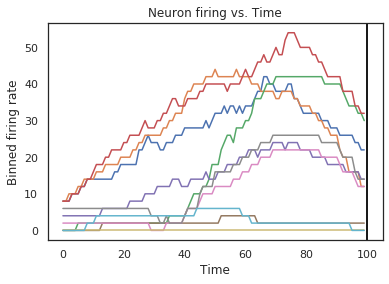

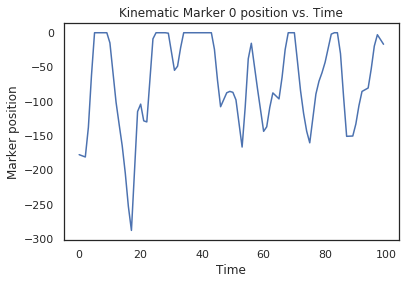

In [132]:
# Number of plots
n = 10

for i in range(n):
    plt.plot(neural_df['rates'].values[i].squeeze())
    plt.title('Neuron firing vs. Time')
    plt.axvline(x=100, color='k')
    plt.xlabel('Time')
    plt.ylabel('Binned firing rate')

plt.figure()
plt.title('Kinematic Marker 0 position vs. Time')
plt.plot(kinematic_df['posData'].values[0].squeeze())
plt.xlabel('Time')
plt.ylabel('Marker position')

In [24]:
from mpl_toolkits.mplot3d import Axes3D

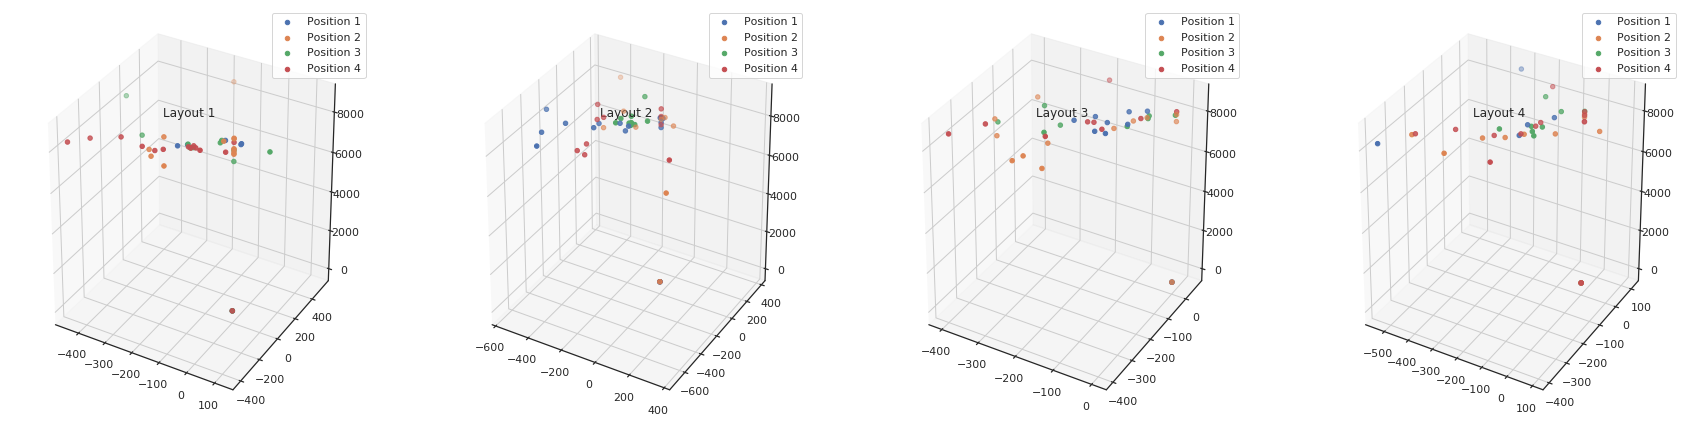

In [26]:
thumb_data_x = kinematic_df[kinematic_df['name'] == 'thumbProx_x'][['posData', 'position', 'layout']].squeeze() 
thumb_data_y =  kinematic_df[kinematic_df['name'] == 'thumbProx_y'][['posData', 'position', 'layout']].squeeze()
thumb_data_z = kinematic_df[kinematic_df['name'] == 'thumbProx_z'][['posData', 'position', 'layout']].squeeze()

np.vstack(thumb_data_x['posData'].values).shape

fig, ax = plt.subplots(1,4, figsize=(30,7.5), subplot_kw=dict(projection='3d'))
plot_types = [(idx1, idx2) for idx1 in range(1,5) for idx2 in range(1,5)]

plot_data = [thumb_data_x, thumb_data_y, thumb_data_z]
for plot_type in plot_types:
    mask = pd.array(np.logical_and(thumb_data_y['layout']==plot_type[0], thumb_data_y['position']==plot_type[1]))
    # for data in plot_data[1:]:
    #     assert mask ==  np.logical_and(data['layout']==plot_type[0], data['position']==plot_type[1])
    
    thumb_data_x_filtered = thumb_data_x[mask]['posData'].str[0]
    thumb_data_y_filtered = thumb_data_y[mask]['posData'].str[0]
    thumb_data_z_filtered = thumb_data_z[mask]['posData'].str[0]

    ax[plot_type[0]-1].scatter3D(thumb_data_x_filtered, thumb_data_y_filtered, thumb_data_z_filtered, label = 'Position ' + str(plot_type[1]))
    ax[plot_type[0]-1].set_title('Layout ' + str(plot_type[0]))
    ax[plot_type[0]-1].legend()
    

## Analyze Data

In [15]:
import sys
sys.path.append('/gpfs/home/loconno3/utra2023/code')
import mocap_functions_copy

In [16]:
kinematic_df, neural_df, video_df, metadata = mocap_functions_copy.load_mocap_df('../data/SPK20220308/task_data/')

sampling_rate = 100
kernel_offset = int(metadata['kernel_halfwidth'] * sampling_rate)  #Convolution kernel centered at zero, add to neural offset
neural_offset = 20
offset = neural_offset + kernel_offset
window_size = 20
data_step_size = 1 

num_trials = metadata['num_trials']



#Generate cv_dict for regular train/test/validate split (no rolling window)
cv_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
val_split = ShuffleSplit(n_splits=1, test_size=.25, random_state=0)
cv_dict = {}
for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(np.arange(num_trials))):
    for t_idx, v_idx in val_split.split(train_val_idx): #No looping, just used to split train/validation sets
        cv_dict[fold] = {'train_idx':train_val_idx[t_idx], 
                         'test_idx':test_idx, 
                         'validation_idx':train_val_idx[v_idx]} 

In [17]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch
import itertools

In [18]:
from sklearn.preprocessing import StandardScaler

### Old Video Dataset Class

In [61]:
class Video_Dataset_old(torch.utils.data.Dataset):
    def __init__(self, cv_dict,  fold, partition, video_path, video_df, neural_df, subsample_scalar=1):
        self.video_path = video_path
        self.reader = torchvision.io.VideoReader(video_path, "video")
        self.md = self.reader.get_metadata()
        self.subsample_scalar = subsample_scalar
        self.video_df = video_df
        self.neural_df = neural_df
        self.cv_dict = cv_dict
        self.fold = fold
        self.partition = partition
        self.trial_idx = cv_dict[fold][partition]
        self.video_datalist, self.neural_datalist = self.process_dfs(video_df, neural_df)
        # Make this more robust
        self.aspect_ratio = (-(1056 // -self.subsample_scalar), -(1440 // -self.subsample_scalar))
        self.y_tensor = self.scale_y_data()
        self.time_stamps = torch.tensor(np.concatenate(self.video_datalist, axis=0))

        self.x_size = self[0][0].shape[2]
        self.y_size = self.y_tensor.shape[1]
        # super().__init__()
    
    '''
    Generates scaled y data
    '''
    def scale_y_data(self):
        scaler = StandardScaler()
        y_tensor = torch.tensor(scaler.fit_transform(np.concatenate(self.neural_datalist, axis=0)))
        return y_tensor

    def process_dfs(self, video_df, neural_df):
        videoData_list, neuralData_list = [], []
        for trial in self.trial_idx:
            # TODO: I'm throwing away the last trial because it spills over the end of the video by several seconds. Look for a more elegant fix!
            if trial != 217:
                videoData_array = np.stack(video_df['timeStamps'][video_df['trial'] == trial].values).transpose() 
                neuralData_array = np.stack(neural_df['rates'][neural_df['trial'] == trial].values).squeeze().transpose() 

                videoData_list.append(videoData_array)
                neuralData_list.append(neuralData_array)

        return videoData_list, neuralData_list
    '''
    Allows time indexing (s) into videos, returns relevant frames. Note that 
    indexes must be floats.

    Returns list(np.array)
    '''
    def __getitem__(self, key):
        frames = []
        
        for time_stamp in self.time_stamps[key]:
            try:
                time_stamp = float(time_stamp.numpy())
                self.reader.seek(time_stamp)
                frame = np.moveaxis(np.array(next(self.reader)['data']), 0, 2)[::self.subsample_scalar,::self.subsample_scalar,0] / 255.0
                frame = np.reshape(frame, (1,-1))
                frames.append(frame)
            except:
                # TODO: FIX UNDERLYING ISSUE!
                print("Warning: an exception occured finding time_stamp: " + str(float(time_stamp.numpy())))
                frame = np.random.rand(1, self.x_size)
                frames.append(frame)

        
        return torch.tensor(frames), self.y_tensor[key,:]


    def __len__(self):
        return self.y_tensor.shape[0]

    """
    Given frames, print them
    """
    def print_frames(self, frames, step=1):
        num_frames = len(frames)
        if num_frames > 1:
            fig, axes = plt.subplots(nrows=1, ncols= -(num_frames // -step), figsize=(24,24))
            i=0
            for n in range(0, num_frames, step):
                #curr_ax = axes[i//8, i%8] 
                curr_ax = axes[i] 
                curr_ax.imshow(np.reshape(frames[n], self.aspect_ratio))
                i+=1
            return fig
        else:
            plt.imshow(np.reshape(frames[0], self.aspect_ratio))
    
    """
    Given time stamp(s), prints the frames at those timestamps
    """
    def print_frame_at_time(self, time_stamp, step=1):
        time_stamp = float(time_stamp)
        self.reader.seek(time_stamp)
        frames = [np.moveaxis(np.array(next(self.reader)['data']), 0, 2)[::self.subsample_scalar,::self.subsample_scalar,0] / 255.0]
        fig = self.print_frames(frames, step)
        return fig

In [82]:
dataset = Video_Dataset_old(cv_dict,  fold, 'train_idx', video_path, video_df, neural_df, subsample_scalar=100)
print(dataset.y_tensor.shape)
print(dataset.)

torch.Size([12200, 87])


### New Video dataset class

TODO: Ask about/test whether loading trialwise or entire thing is better

In [129]:
class Video_Dataset(torch.utils.data.Dataset):
    def __init__(self, cv_dict,  fold, partition, video_path, video_df, neural_df, subsample_scalar=1, load_from_pickle=True):
        self.video_path = video_path
        self.reader = torchvision.io.VideoReader(video_path, "video")
        self.md = self.reader.get_metadata()
        self.subsample_scalar = subsample_scalar
        self.video_df = video_df
        self.neural_df = neural_df
        self.cv_dict = cv_dict
        self.fold = fold
        self.partition = partition
        self.trial_idx = cv_dict[fold][partition]
        self.load_from_pickle = load_from_pickle
        self.video_datalist, self.neural_datalist, self.frame_datalist = self.process_dfs(video_df, neural_df)
        # Make this more robust
        self.aspect_ratio = (math.floor(((1056-100+2*0)/subsample_scalar)+1),math.floor(((1440-100+2*0)/subsample_scalar)+1))
        self.y_tensor = self.scale_y_data()
        self.time_stamps = torch.tensor(np.concatenate(self.video_datalist, axis=0))
        self.x_size = self[0][0].shape[1]
        self.y_size = self.y_tensor.shape[1]
        

        # super().__init__()
    
    '''
    Generates scaled y data
    '''
    def scale_y_data(self):
        scaler = StandardScaler()
        y_tensor = torch.tensor(scaler.fit_transform(np.concatenate(self.neural_datalist, axis=0)))
        return y_tensor
    
    '''
    Generates processed data
    '''
    def process_dfs(self, video_df, neural_df):
        videoData_list, neuralData_list = [], []
        for trial in self.trial_idx:
            # TODO: I'm throwing away the last trial because it spills over the end of the video by several seconds. Look for a more elegant fix!
            if trial != 217:
                videoData_array = np.stack(video_df['timeStamps'][video_df['trial'] == trial].values).transpose() 
                neuralData_array = np.stack(neural_df['rates'][neural_df['trial'] == trial].values).squeeze().transpose() 

                videoData_list.append(videoData_array)
                neuralData_list.append(neuralData_array) 
        
        if self.load_from_pickle:
            frame_data_list = self.load_frame_datalist(video_df)
        else:
            frame_data_list = self.save_frame_datalist(video_df)
        
        frame_data_list = frame_data_list.reshape([-1,1, frame_data_list.shape[2]])
        return videoData_list, neuralData_list, frame_data_list
    
    '''
    Helper function for pickling frame data
    '''
    def save_frame_datalist(self, video_df):
        frame_data_list = list()
        pooler = torch.nn.AvgPool2d(kernel_size=100, stride=self.subsample_scalar)
        # For each trial in the partition, save all frames as a pickle and add to returned data list
        for idx in self.trial_idx:
            if idx != 217:
                print(idx, end=' ')
                frame_times = video_df['timeStamps'][idx]
                frame_trial = list()
                for ftime in frame_times:
                    self.reader.seek(ftime - cam_start)
                    frame = next(self.reader)
                    frame_pooled = pooler(frame['data'].float())
                    frame_trial.append(frame_pooled[0, :, :].reshape(-1))

                frame_data_list.append(torch.stack(frame_trial))
                with open(f'../data/SPK20220308/frames/frame_trial{idx}', 'wb') as handle:
                    pickle.dump(torch.stack(frame_trial), handle, protocol=pickle.HIGHEST_PROTOCOL)
        return torch.stack(frame_data_list)
        
    '''
    Helper function for unpickling frame data
    '''
    def load_frame_datalist(self, video_df):
        frame_data_list = []
        # For each trial in the partition, load the frames from pickle and append to our returned data list
        for idx in self.trial_idx:
            # Still throwing away 217
            if idx != 217:
                print(idx, end=' ')
                with open(f'../data/SPK20220308/frames/frame_trial{idx}', 'rb') as handle:
                     frame_trial = pickle.load(handle)
                frame_data_list.append(frame_trial)
        return torch.stack(frame_data_list)
                
                
    '''
    Allows time indexing (s) into videos, returns relevant frames. Note that 
    indexes must be floats.

    Returns list(np.array)
    '''
    def __getitem__(self, key):
        return self.frame_datalist[key], self.y_tensor[key,:]
            
            

    def __len__(self):
        return self.y_tensor.shape[0]

    """
    Given frames, print them
    """
    def print_frames(self, frames, step=1):
        num_frames = frames.shape[0]
        if num_frames > 1:
            fig, axes = plt.subplots(nrows=1, ncols= -(num_frames // -step), figsize=(24,24))
            i=0
            for n in range(0, num_frames, step):
                #curr_ax = axes[i//8, i%8] 
                curr_ax = axes[i] 
                curr_ax.imshow(np.reshape(frames[n], self.aspect_ratio))
                i+=1
            return fig
        else:
            plt.imshow(np.reshape(frames[0], self.aspect_ratio))
            
    """
    Print the unblurred frames
    """
    def print_original_frames(self, frame_ids):
        frame_times = self.time_stamps[frame_ids]
        num_frames = frame_times.shape[0]
        frames = []
        if num_frames > 1:
            step=1
            fig, axes = plt.subplots(nrows=1, ncols= -(num_frames // -step), figsize=(24,24))
            i=0
            for time_stamp in frame_times:
                self.reader.seek(time_stamp - cam_start)
                frame = np.moveaxis(np.array(next(self.reader)['data']), 0, 2)
                curr_ax = axes[i] 
                curr_ax.imshow(frame)
                i+=1
            return
        else:
            self.reader.seek(frame_times[0] - cam_start)
            frame = np.moveaxis(np.array(next(self.reader)['data']), 0, 2)
            plt.imshow(frame)
            return

In [102]:
class Baseline_Dataset(Video_Dataset):
    def __init__(self, cv_dict,  fold, partition, video_path, video_df, neural_df, subsample_scalar=1, load_from_pickle=False):
        super().__init__(cv_dict,  fold, partition, video_path, video_df, neural_df, subsample_scalar=subsample_scalar, load_from_pickle=load_from_pickle)
        self.y_tensor_real = self.y_tensor
        self.y_tensor = torch.broadcast_to(torch.mean(self.y_tensor,0), [self.y_tensor.shape[0], self.y_tensor.shape[1]])

82 210 85 135 59 87 40 100 115 110 130 211 187 206 133 205 203 213 48 140 160 199 83 7 158 137 4 117 112 188 111 65 159 119 77 45 96 26 129 215 71 53 118 174 43 91 1 122 46 184 102 208 156 164 202 185 131 168 28 101 16 18 143 114 195 78 64 10 142 194 121 30 95 42 128 60 113 149 108 165 63 139 2 124 17 127 148 154 89 116 162 161 57 167 134 29 86 144 163 170 21 11 19 176 181 216 81 123 106 55 51 126 24 178 197 138 73 75 8 25 109 15 

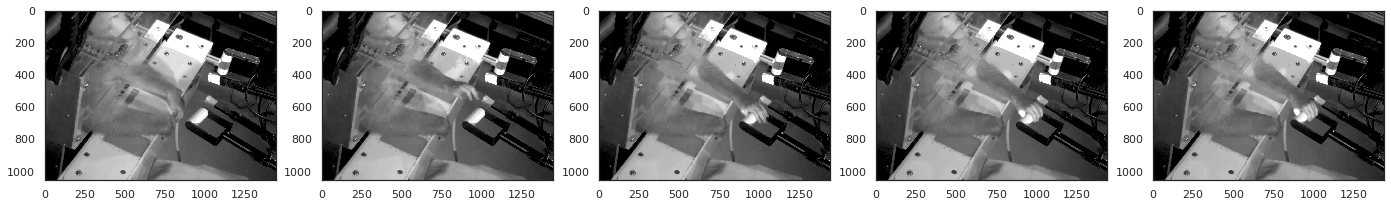

In [131]:
video_path = "/gpfs/home/loconno3/utra2023/data/SpikeCam3_03-08-1557.mp4"
dataset = Video_Dataset(cv_dict,  fold, 'train_idx', video_path, video_df, neural_df, subsample_scalar=40, load_from_pickle=True)
dataset.print_original_frames(range(400,500,20))

14.851

Baseline: average firing rate for each of 16 conditions without the one being predicted
    r^2, mse, correlation of ^

Write-up
    Lit search
    Carlos will send outline
    Define problem
    Description of data
    Analysis and Methods
        Baseline
        Architectures
    Results
        Quantitative
        Which neurons can predict well?
            Visualize the distributions, compare to baseline
        Chance distribution: Shuffle trials
            Montecarlo methods estimate chance of some metric-> above chance? matched pair better than 
            Empirical chance distribution
            Is there a subset(s) above chance?
                Cortical area
                    Plot % vs R^2

Start: 1 frame -> all neurons at that point
Submit updates as pull request to original repo: make branch, checkout, push
Use paperpile for references- works with google docs


# ANN Decoding

In [63]:
import sys
sys.path.append('/gpfs/home/loconno3/utra2023/code')
import mocap_functions_copy

## Initialize Data

In [64]:
# Set to True to train on average values
is_baseline = False
batch_size = 256
subsample_scalar = 40

In [66]:
video_path = "/gpfs/home/loconno3/utra2023/data/SpikeCam3_03-08-1557.mp4"
train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}
validation_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
test_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}

if is_baseline:
    training_set = Baseline_Dataset(cv_dict,  fold, 'train_idx', video_path, video_df, neural_df, subsample_scalar=subsample_scalar)
    # X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
    # y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()
    validation_set = Baseline_Dataset(cv_dict,  fold, 'validation_idx', video_path, video_df, neural_df, subsample_scalar=subsample_scalar)
    testing_set = Baseline_Dataset(cv_dict,  fold, 'test_idx', video_path, video_df, neural_df, subsample_scalar=subsample_scalar)

else:
    training_set = Video_Dataset(cv_dict,  fold, 'train_idx', video_path, video_df, neural_df, subsample_scalar=subsample_scalar, load_from_pickle=True)
    validation_set = Video_Dataset(cv_dict,  fold, 'validation_idx', video_path, video_df, neural_df, subsample_scalar=subsample_scalar, load_from_pickle=True)
    testing_set = Video_Dataset(cv_dict,  fold, 'test_idx', video_path, video_df, neural_df, subsample_scalar=subsample_scalar, load_from_pickle=True)
    
    # X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
    # y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

82 210 85 135 59 87 40 100 115 110 130 211 187 206 133 205 203 213 48 140 160 199 83 7 158 137 4 117 112 188 111 65 159 119 77 45 96 26 129 215 71 53 118 174 43 91 1 122 46 184 102 208 156 164 202 185 131 168 28 101 16 18 143 114 195 78 64 10 142 194 121 30 95 42 128 60 113 149 108 165 63 139 2 124 17 127 148 154 89 116 162 161 57 167 134 29 86 144 163 170 21 11 19 176 181 216 81 123 106 55 51 126 24 178 197 138 73 75 8 25 109 15 150 169 97 153 38 3 41 52 186 9 157 155 37 98 183 147 67 74 5 94 198 99 68 35 179 92 93 132 84 145 6 90 88 120 189 22 125 23 152 172 27 171 31 193 44 69 214 80 76 20 79 61 105 192 103 62 204 175 146 201 191 56 196 107 177 36 58 104 0 173 212 141 32 207 13 190 136 33 200 180 209 49 34 166 50 39 151 66 12 70 47 14 54 72 182 

In [163]:
x_plot = training_set[0:1000][0]

  0%|          | 0/48 [2:20:40<?, ?it/s]


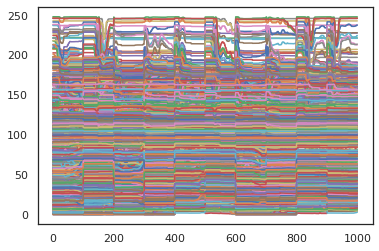

In [164]:
_ = plt.plot(x_plot.numpy().squeeze())

## ANN Model

### Hyperparameters and Model Initialization

In [67]:
#Define hyperparameters
lr = 1e-2
weight_decay = 1e-5
layer_size=[512, 256]
max_epochs=100
input_size = training_set.x_size
output_size = training_set.y_size

model_ann = mocap_functions_copy.model_ann(input_size,output_size,layer_size, batch_size=batch_size).to(device)
# Define Loss, Optimizerints h
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_ann.parameters(), lr=lr, weight_decay=weight_decay)

In [133]:
print(training_set.x_size)

816


### Train

In [68]:
#Train model
loss_dict = mocap_functions_copy.train_validate_model(model_ann, optimizer, criterion, max_epochs, training_set, validation_set, device)

Begun training, validating
Epoch: 0


  0%|          | 0/48 [00:00<?, ?it/s]/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
 88%|████████▊ | 42/48 [00:00<00:00, 68.06it/s]

Evaluating



  0%|          | 0/16 [00:00<?, ?it/s]

*Epoch: 1




100%|██████████| 48/48 [00:00<00:00, 60.87it/s]


 15%|█▍        | 7/48 [00:00<00:00, 65.44it/s]

 29%|██▉       | 14/48 [00:00<00:00, 64.76it/s]

 44%|████▍     | 21/48 [00:00<00:00, 63.62it/s]

 58%|█████▊    | 28/48 [00:00<00:00, 64.11it/s]

 73%|███████▎  | 35/48 [00:00<00:00, 64.52it/s]

 88%|████████▊ | 42/48 [00:00<00:00, 64.56it/s]

Evaluating


100%|██████████| 16/16 [00:00<00:00, 19.60it/s]


.Epoch: 2



100%|██████████| 48/48 [00:00<00:00, 58.48it/s]

 88%|████████▊ | 42/48 [00:00<00:00, 65.08it/s]

Evaluating




100%|██████████| 16/16 [00:00<00:00, 19.49it/s]


.Epoch: 3


 88%|████████▊ | 42/48 [00:00<00:00, 68.12it/s]

Evaluating



100%|██████████| 16/16 [00:00<00:00, 20.47it/s]


.Epoch: 4




100%|██████████| 48/48 [00:00<00:00, 61.04it/s]


 15%|█▍        | 7/48 [00:00<00:00, 66.33it/s]

 29%|██▉       | 14/48 [00:00<00:00, 65.11it/s]

 44%|████▍     | 21/48 [00:00<00:00, 64.82it/s]

 58%|█████▊    | 28/48 [00:00<00:00, 64.50it/s]

 73%|███████▎  | 35/48 [00:00<00:00, 64.68it/s]

 88%|████████▊ | 42/48 [00:00<00:00, 64.61it/s]

Evaluating


100%|██████████| 16/16 [00:00<00:00, 19.52it/s]


.Epoch: 5



100%|██████████| 48/48 [00:00<00:00, 58.59it/s]

 88%|████████▊ | 42/48 [00:00<00:00, 65.07it/s]

Evaluating




100%|██████████| 16/16 [00:00<00:00, 19.51it/s]


.Epoch: 6


 88%|████████▊ | 42/48 [00:00<00:00, 68.54it/s]

Evaluating



100%|██████████| 16/16 [00:00<00:00, 20.45it/s]


.Epoch: 7




100%|██████████| 48/48 [00:00<00:00, 61.05it/s]


 15%|█▍        | 7/48 [00:00<00:00, 66.15it/s]

 29%|██▉       | 14/48 [00:00<00:00, 64.89it/s]

 44%|████▍     | 21/48 [00:00<00:00, 65.10it/s]

 58%|█████▊    | 28/48 [00:00<00:00, 64.90it/s]

 73%|███████▎  | 35/48 [00:00<00:00, 65.13it/s]

 88%|████████▊ | 42/48 [00:00<00:00, 64.79it/s]

Evaluating


100%|██████████| 16/16 [00:00<00:00, 19.57it/s]


.Epoch: 8



100%|██████████| 48/48 [00:00<00:00, 58.67it/s]

 88%|████████▊ | 42/48 [00:00<00:00, 64.68it/s]

Evaluating




100%|██████████| 16/16 [00:00<00:00, 19.43it/s]


.Epoch: 9


 88%|████████▊ | 42/48 [00:00<00:00, 68.24it/s]

Evaluating



100%|██████████| 16/16 [00:00<00:00, 20.47it/s]


.
Epoch: 10/100 ... Train Loss: 1.9550  ... Validation Loss: 1.9547
Epoch: 10




100%|██████████| 48/48 [00:00<00:00, 61.03it/s]


 15%|█▍        | 7/48 [00:00<00:00, 67.03it/s]

 29%|██▉       | 14/48 [00:00<00:00, 65.16it/s]

 44%|████▍     | 21/48 [00:00<00:00, 64.85it/s]

 58%|█████▊    | 28/48 [00:00<00:00, 64.75it/s]

 73%|███████▎  | 35/48 [00:00<00:00, 64.74it/s]

 88%|████████▊ | 42/48 [00:00<00:00, 64.84it/s]

Evaluating


100%|██████████| 16/16 [00:00<00:00, 19.59it/s]


.Epoch: 11



100%|██████████| 48/48 [00:00<00:00, 58.83it/s]

 88%|████████▊ | 42/48 [00:00<00:00, 64.71it/s]

Evaluating




100%|██████████| 16/16 [00:00<00:00, 19.47it/s]


.Epoch: 12


 90%|████████▉ | 43/48 [00:00<00:00, 69.72it/s]

Evaluating



100%|██████████| 16/16 [00:00<00:00, 20.65it/s]


.Epoch: 13




100%|██████████| 48/48 [00:00<00:00, 61.81it/s]


 15%|█▍        | 7/48 [00:00<00:00, 69.77it/s]

 29%|██▉       | 14/48 [00:00<00:00, 68.48it/s]

 44%|████▍     | 21/48 [00:00<00:00, 68.46it/s]

 58%|█████▊    | 28/48 [00:00<00:00, 68.31it/s]

 73%|███████▎  | 35/48 [00:00<00:00, 68.48it/s]

 88%|████████▊ | 42/48 [00:00<00:00, 68.58it/s]

Evaluating


100%|██████████| 16/16 [00:00<00:00, 20.63it/s]


.Epoch: 14



100%|██████████| 48/48 [00:00<00:00, 61.80it/s]

 92%|█████████▏| 44/48 [00:00<00:00, 68.45it/s]

Evaluating




100%|██████████| 16/16 [00:00<00:00, 20.42it/s]


.Epoch: 15


100%|██████████| 48/48 [00:00<00:00, 71.80it/s]

Evaluating



100%|██████████| 16/16 [00:00<00:00, 21.26it/s]


.Epoch: 16




100%|██████████| 48/48 [00:00<00:00, 63.41it/s]


 15%|█▍        | 7/48 [00:00<00:00, 69.94it/s]

 29%|██▉       | 14/48 [00:00<00:00, 68.42it/s]

 44%|████▍     | 21/48 [00:00<00:00, 68.17it/s]

 58%|█████▊    | 28/48 [00:00<00:00, 68.38it/s]

 73%|███████▎  | 35/48 [00:00<00:00, 68.42it/s]

 88%|████████▊ | 42/48 [00:00<00:00, 68.25it/s]

Evaluating


100%|██████████| 16/16 [00:00<00:00, 20.56it/s]


.Epoch: 17



100%|██████████| 48/48 [00:00<00:00, 61.66it/s]

 88%|████████▊ | 42/48 [00:00<00:00, 68.16it/s]

Evaluating




100%|██████████| 16/16 [00:00<00:00, 20.41it/s]


.Epoch: 18


 98%|█████████▊| 47/48 [00:00<00:00, 71.50it/s]

Evaluating



100%|██████████| 16/16 [00:00<00:00, 21.27it/s]


.Epoch: 19




100%|██████████| 48/48 [00:00<00:00, 63.51it/s]


 17%|█▋        | 8/48 [00:00<00:00, 69.62it/s]

 31%|███▏      | 15/48 [00:00<00:00, 68.40it/s]

 46%|████▌     | 22/48 [00:00<00:00, 67.98it/s]

 60%|██████    | 29/48 [00:00<00:00, 67.80it/s]

 75%|███████▌  | 36/48 [00:00<00:00, 67.38it/s]

 90%|████████▉ | 43/48 [00:00<00:00, 67.18it/s]

Evaluating


100%|██████████| 16/16 [00:00<00:00, 20.34it/s]


.
Epoch: 20/100 ... Train Loss: 1.9477  ... Validation Loss: 1.9470
Epoch: 20



100%|██████████| 48/48 [00:00<00:00, 60.76it/s]

 88%|████████▊ | 42/48 [00:00<00:00, 65.86it/s]

Evaluating




100%|██████████| 16/16 [00:00<00:00, 19.64it/s]


.Epoch: 21


 88%|████████▊ | 42/48 [00:00<00:00, 68.60it/s]

Evaluating



100%|██████████| 16/16 [00:00<00:00, 236.33it/s]

. Early Stop; Min Epoch: 1


In [69]:
loss_dict
print("Minimum validation loss: " + str(loss_dict['min_validation_loss']))
print("Minimum validation STD: " + str(loss_dict['min_validation_std']))
print("Epoch of minimum validation loss: " + str(loss_dict['min_validation_epoch']))
print("Minimum training loss: " + str(loss_dict['min_train_loss']))
print("Minimum training STD: " + str(loss_dict['min_train_std']))

Minimum validation loss: 1.849061481654644
Minimum validation STD: 0.20140945887331851
Epoch of minimum validation loss: 1
Minimum training loss: 1.6769009456038475
Minimum training STD: 0.315724450844267


In [156]:
model_ann

model_ann(
  (layer_list): ModuleList(
    (0): Linear(in_features=816, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=87, bias=True)
  )
)

In [74]:
np.concatenate(loss_dict['train_loss_array'])

array([1.19772363, 1.30269825, 1.59823382, ..., 2.24040556, 1.7997247 ,
       1.62000108])

Text(0, 0.5, 'MSE Loss')

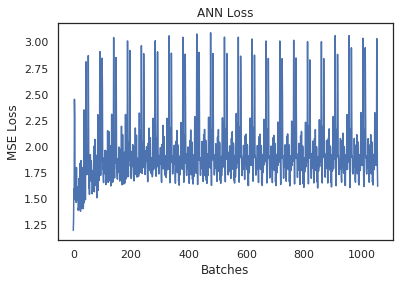

In [75]:
loss_data = np.concatenate(loss_dict['train_loss_array'])
batches = list(range(len(loss_data)))

plt.title('ANN Loss')
plt.plot(batches, loss_data)
plt.xlabel('Batches')
plt.ylabel('MSE Loss')

### Evaluate

In [158]:
x = training_set.y_tensor
y = validation_set.y_tensor
x = torch.broadcast_to(torch.mean(x,0), [y.shape[0], y.shape[1]])
loss = torch.nn.MSELoss()
loss(x,y)

tensor(1., dtype=torch.float64)

In [159]:
from tqdm.auto import tqdm

In [160]:
#Helper function to evaluate decoding performance on a trained model
def evaluate_model_n(model, dataset, device):
    #Run model through test set
    with torch.no_grad():
        model.eval()
        #Generate train set predictions
        y_pred_tensor = torch.zeros(len(dataset), dataset.y_tensor.shape[1])
        batch_idx = 0
        progress_bar = tqdm(range(0, len(dataset), batch_size))
        #for b in range(0, len(dataset), batch_size):
        for b in range(0, batch_size, batch_size):
            batch_x, batch_y = dataset[b:b+batch_size]
#             batch_x, _ = dataset[b:b+batch_size]
#             batch_y = new_training_set.y_tensor_real[b:b+batch_size]
            batch_x = batch_x.float().to(device)
            batch_y = batch_y.float().to(device)
            output = model(batch_x)
            y_pred_tensor[batch_idx:(batch_idx+output.size(0)),:] = output[:,-1,:]
            batch_idx += output.size(0)
            progress_bar.update(1)

    y_pred = y_pred_tensor.detach().cpu().numpy()
    return y_pred

In [161]:
#Evaluate trained model
ann_train_pred = evaluate_model_n(model_ann, training_set, device)

ann_test_pred = evaluate_model_n(model_ann, testing_set, device)

#Compute decoding performance
y_train_data = training_set.y_tensor
y_test_data = testing_set.y_tensor
# ann_train_corr = mocap_functions_copy.matrix_corr(ann_train_pred,y_train_data)
# ann_test_corr = mocap_functions_copy.matrix_corr(ann_test_pred,y_test_data)


  0%|          | 0/48 [00:00<?, ?it/s]/users/loconno3/anaconda/SEE/lib/python3.7/site-packages/torch/nn/functional.py:1956: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
  2%|▏         | 1/48 [00:00<00:00, 176.06it/s]

  5%|▍         | 1/22 [00:00<00:00, 193.89it/s]


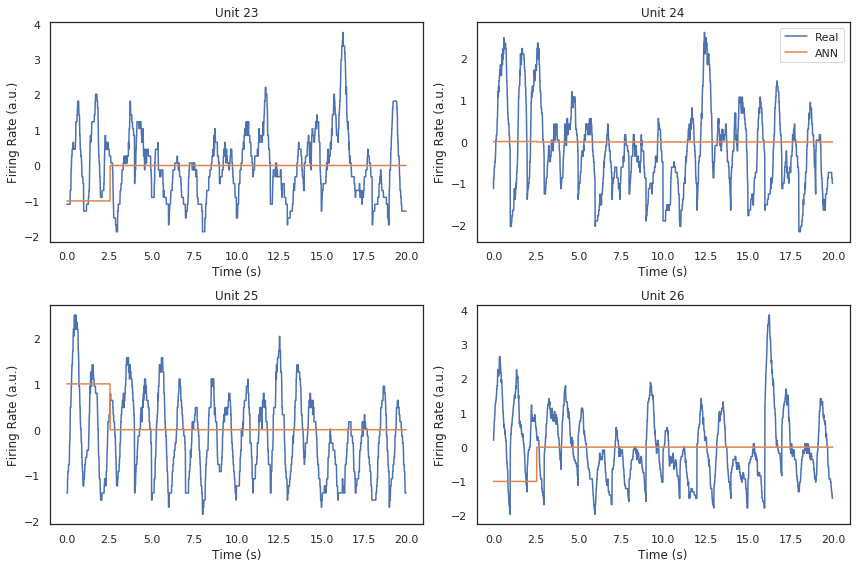

In [162]:
#Testing Data
y_train_data = training_set.y_tensor
y_test_data = testing_set.y_tensor
start=23
plt.figure(figsize=(12,8))
bounds = np.arange(1,2000)
x_vals = np.arange(len(bounds)) / 100
for plot_idx, unit_idx in enumerate(range(start, start+4)):
    plt.subplot(2,2,plot_idx+1)
    plt.plot(x_vals,y_test_data[bounds,unit_idx])
    # plt.plot(x_vals,kf_test_pred[bounds,unit_idx])
    plt.plot(x_vals,ann_test_pred[bounds,unit_idx])
    plt.title('Unit ' + str(unit_idx))
    plt.xlabel('Time (s)')
    plt.ylabel('Firing Rate (a.u.)')
    if plot_idx==1:
        plt.legend(['Real', 'ANN'], loc=1)
plt.tight_layout()

In [152]:
print(ann_train_pred.shape)
x = torch.tensor(ann_train_pred)
y = new_training_set.y_tensor_real[:12200]
print(y_train_data.shape)

loss = torch.nn.MSELoss()
loss(x,y)

(12200, 87)


NameError: name 'new_training_set' is not defined

(array([ 2.,  8., 20., 21., 19.,  8.,  6.,  2.,  0.,  1.]),
 array([-0.14681974, -0.10786434, -0.06890894, -0.02995354,  0.00900187,
         0.04795727,  0.08691267,  0.12586807,  0.16482347,  0.20377888,
         0.24273428]),
 <a list of 10 Patch objects>)

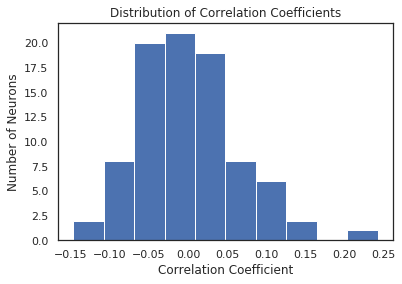

In [94]:
ann_train_corr = mocap_functions_copy.matrix_corr(ann_train_pred,y_train_data.numpy())
plt.title('Distribution of Correlation Coefficients')
plt.ylabel('Number of Neurons')
plt.xlabel('Correlation Coefficient')
plt.hist(ann_train_corr)

In [95]:
print(np.mean(ann_train_corr))

0.0002977525434909899


Row number not as meaningful: each is time slice
Check out pandas filtering:
   kinematic_df[kinematic_df['name'] == 'thumbProx_x']
Can use logical operators, eg:
   kinematic_df[np.logical_and(kinematic_df['name'] == 'thumbProx_x', kinematic_df['name'] == 'thumbProx_y')]
Mapping operations

TO DO for 11/11
- Get snapshots from video?
- Try plots of different markers
- Make sure that position and layout arent confused
- Video loader:
   -> Something that takes in videodata, out neuron fr
   -> Start without DR
   -> define index/frame, get portion of video
   -> Same indexing as contact points/trial/cells
   -> plots frame of video
   -> use _getitem for indexing video
   -> Wiener filter?
   -> get pipeline together

TO-DO for next week 10/28:
-Contact point plot: Marker (thumb and index?) location at point of contact
    -> Carefully choose which one plotting, some tracking bad
    -> Position, object, orientation for each of 16 conditions
    -> How much overlap between conditions
    -> One layout at a time (4 plots)
    -> Color by object being grasped


Long term:
    Start writing code for data loader class: video loader, act like np array, index, spit out processed frame
    Look at different video formats: mp4 vs raw
    Package: Open CV (import cv2)
    Try training on MLP, even linear regression, see if can get working, then can expand and use more complicated architectures



read_video(filename[,start_pts, end_pts,...])
Reads a video from a file, returning both the video frames as well as audio frames
read_video_timestamps(filename[,pts_unit]) list the video frames timestamps

[T,H,W,C]??

12/13
Code to make sample plots
real neuron traces vs predicted traces
prioritize write up
overlay predicted vs actual- Note correlation for one showing

for each neuron error between predicted and true, histogram of errors over time points, one per neuron

distribution of MSEs

histogram of correlation coefficients?


For methods, talk about whole pipeline
    Example frame of full resolution, what it looks like after downsampling

In [ ]:
# Set up PyTorch Dataloaders
fold=0
kinematic_type = 'posData'
# Parameters
batch_size = 10000
train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}
validation_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
test_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}

predict_kinematics=False
# Generators
training_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'train_idx', kinematic_df, neural_df, offset, window_size, 
                                            data_step_size, device, 'posData', True, predict_kinematics)
training_generator = torch.utils.data.DataLoader(training_set, **train_params)
training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)
X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

validation_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'validation_idx', kinematic_df, neural_df, offset, window_size, 
                                                data_step_size, device, 'posData', True, predict_kinematics)
validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

testing_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'test_idx', kinematic_df, neural_df, offset, window_size, 
                                                data_step_size, device, 'posData', True, predict_kinematics)
testing_generator = torch.utils.data.DataLoader(testing_set, **test_params)
X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

In [ ]:
training_set[10][0].shape
# First is different markers, second is 

11/26 start with window size 1
cv_dict -> which trials belong to which fold
video df but where kinematic is timestamps, in get item pull from
mocap functions SEE_Dataset
store torch video loader
One row, trial, frame indices
create bare bones dataset
index, pulls out frame at time point

In [ ]:
neural_list = list()
video_list = list()
for trial_idx in range(10):
    neural_list.append(neural_df[neural_df['trial'] == trial_idx]['rates'].values.squeeze())
    video_list.append(video_df[video_df['trial'] == trial_idx]['timeStamps'].values.squeeze())


[array([array([[ 6.,  6.,  8., 10., 10., 12., 12., 14., 16., 18., 20., 26., 28.,
                32., 34., 34., 34., 34., 34., 36., 38., 38., 38., 38., 38., 38.,
                40., 40., 40., 40., 40., 40., 42., 44., 42., 42., 42., 42., 44.,
                46., 48., 48., 48., 46., 48., 50., 50., 52., 56., 58., 60., 64.,
                68., 66., 64., 64., 62., 62., 60., 58., 56., 54., 48., 46., 42.,
                40., 40., 40., 40., 40., 38., 36., 36., 36., 36., 36., 36., 36.,
                36., 36., 36., 36., 38., 36., 34., 34., 34., 34., 34., 34., 32.,
                32., 32., 32., 32., 30., 28., 26., 24., 20., 18., 16., 12.,  8.,
                 8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
                 8., 10., 10., 12., 12., 12., 12., 12., 12., 12., 12., 10., 10.,
                10., 10., 10.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  6.,  6.,  4.,
                 4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  6.,  6.,
                 8.,  8., 10

Kalman Filter decoding

In [ ]:
#Fit and run kalman filter
model_kf = Neural_Decoding.decoders.WienerFilterDecoder() 
model_kf.fit(X_train_data,y_train_data)

kf_train_pred = model_kf.predict(X_train_data)
kf_test_pred = model_kf.predict(X_test_data)

#Compute decoding performance
kf_train_corr = mocap_functions.matrix_corr(kf_train_pred,y_train_data)
kf_test_corr = mocap_functions.matrix_corr(kf_test_pred,y_test_data)


: 

In [ ]:
%matplotlib inline
plt.imshow(kf_test_pred,aspect='auto')

: 

: 

ANN Decoding

In [ ]:
#Define hyperparameters
lr = 1e-2
weight_decay = 1e-5
layer_size=[10, 10]
max_epochs=1000
input_size = training_set[0][0].shape[1] 
output_size = training_set[0][1].shape[1] 

model_ann = mocap_functions.model_ann(input_size,output_size,layer_size).to(device)
# Define Loss, Optimizerints h
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_ann.parameters(), lr=lr, weight_decay=weight_decay)

: 

In [ ]:
#Train model
loss_dict = mocap_functions.train_validate_model(model_ann, optimizer, criterion, max_epochs, training_generator, validation_generator, device, 10, 5)

: 

In [ ]:
#Evaluate trained model
ann_train_pred = mocap_functions.evaluate_model(model_ann, training_eval_generator, device)
ann_test_pred = mocap_functions.evaluate_model(model_ann, testing_generator, device)

#Compute decoding performance
ann_train_corr = mocap_functions.matrix_corr(ann_train_pred,y_train_data)
ann_test_corr = mocap_functions.matrix_corr(ann_test_pred,y_test_data)


: 

Visualize Results

NameError: name 'kf_test_pred' is not defined

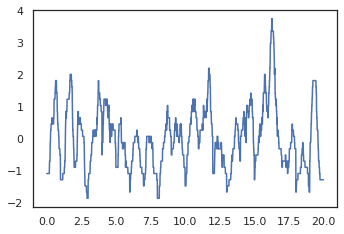

In [60]:
#Testing Data
start=23
plt.figure(figsize=(12,8))
bounds = np.arange(1,2000)
x_vals = np.arange(len(bounds)) / 100
for plot_idx, unit_idx in enumerate(range(start, start+4)):
    plt.subplot(2,2,plot_idx+1)
    plt.plot(x_vals,y_test_data[bounds,unit_idx])
    plt.plot(x_vals,kf_test_pred[bounds,unit_idx])
    plt.plot(x_vals,ann_test_pred[bounds,unit_idx])
    plt.title('Unit ' + str(unit_idx))
    plt.xlabel('Time (s)')
    plt.ylabel('Firing Rate (a.u.)')
    if plot_idx==1:
        plt.legend(['Real', 'KF', 'ANN'], loc=1)
plt.tight_layout()

: 